#Banking Campaign Output Prediction

##Reading Input and loading required libraries

In [6]:
#Please upload the file here
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout
from sklearn.metrics import roc_auc_score
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
sns.set_style("whitegrid")

In [8]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
#checking for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [10]:
#data has a lot of unknown values
unknown_cols = df.isin(['unknown']).sum(axis=0)
unknown_cols

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

It is clear that a lot of unknown values are present in categorical data.

**Separating Target and Feature columns**

In [11]:
#target column
target=df['y']

#feature columns
df=df.drop(['y','duration'],axis=1)

Column ‘duration’ is removed. This attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. All other features are used for training the model.


In [12]:
# selecting categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [13]:
# selecting numerical columns
numerical_cols = df.select_dtypes(exclude=['object']).columns
numerical_cols

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

##Data Pre-preprocessing categorical, numerical and target variables

In [14]:
# filling all the unknow values in categorical columns using mode
for i in categorical_cols:
  mode = df[i].mode()[0]
  df[i] = df[i].replace('unknown',mode)

In [15]:
count = 0

for i in categorical_cols:
  count+=df[i].nunique()

count

47

In [16]:
#encoding categorical data into columns of 0s and 1s
df1 = pd.get_dummies(df[categorical_cols])
df1

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [17]:
#Scaling all the numerical columns
scaler = StandardScaler()
df2 = scaler.fit_transform(df[numerical_cols])
df2 = pd.DataFrame(df2, columns=numerical_cols)
df2.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
1,1.628993,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
2,-0.290186,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
3,-0.002309,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
4,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168


In [18]:
#combining the categorical and numerical features
df = pd.concat([df1,df2],axis=1)
df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1.628993,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,-0.290186,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,-0.002309,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1.533034,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168


In [19]:
#Converting yes and no of target variable to 0 and 1

def convert(x):
    if x == "no":
        return 0
    else:
        return 1
    
y = target.apply(lambda x: convert(x))

In [20]:
# Diving data into training and testing samples
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=0)

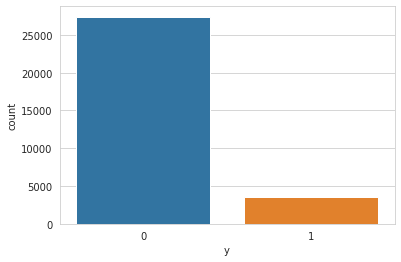

In [21]:
# Looking at the data imbalanced in target variable
sns.countplot(data=pd.DataFrame(y_train),x='y')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


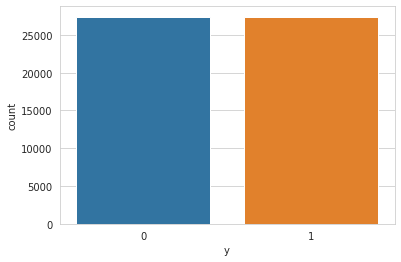

In [22]:
# Data balancing using SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
#after balancing data
sns.countplot(y_train)

In [23]:
X_train.shape

(54818, 56)

## Creating Neural Network

In [24]:
#Defining model
model = Sequential()
#Hidden Layers
model.add(Dense(20, activation='relu',input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(10,activation='relu'))

#Output Layers
model.add(Dense(1,activation='sigmoid'))

#compiling model
model.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])

callbacks = [EarlyStopping(monitor="val_loss", patience=1),ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1140      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train, y_train,epochs=10,validation_data=(X_test,y_test),callbacks= callbacks ,verbose=1)

Epoch 1/10
1714/1714 [==============================] - 5s 2ms/step - loss: 0.5094 - accuracy: 0.7510 - val_loss: 0.4258 - val_accuracy: 0.8610
Epoch 2/10
1714/1714 [==============================] - 3s 2ms/step - loss: 0.3295 - accuracy: 0.8672 - val_loss: 0.3158 - val_accuracy: 0.8877
Epoch 3/10
1714/1714 [==============================] - 3s 2ms/step - loss: 0.2641 - accuracy: 0.8984 - val_loss: 0.2923 - val_accuracy: 0.8926
Epoch 4/10
1714/1714 [==============================] - 3s 2ms/step - loss: 0.2473 - accuracy: 0.9042 - val_loss: 0.2982 - val_accuracy: 0.8870


In [ ]:
#Plottong loass and accuracy of trainind and validation sets
pd.DataFrame(model.history.history).plot()

##Model Performance Evaluation

In [35]:
# Classification report for precision,reaccl,f1-score of each class, and accuracy of over all model

y_pred = (model.predict(X_test)).round().astype("int32")
print(classification_report(y_test, y_pred))

#confusion matrix
print('Confusion matrix : ')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      9139
           1       0.50      0.42      0.46      1158

    accuracy                           0.89     10297
   macro avg       0.71      0.68      0.70     10297
weighted avg       0.88      0.89      0.88     10297

Confusion matrix : 
[[8644  495]
 [ 669  489]]


accuracy of the over-all model: 89%

In [39]:
# AUC Score of the model
auc_score = roc_auc_score(y_test, model.predict(X_test))
print('AUC score of the model is :',auc_score)

# roc curve for models
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

AUC score of the model is : 0.7839884051364826


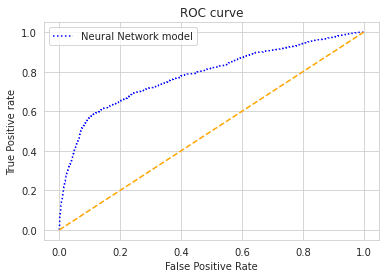

In [41]:
# Plotting ROC Curve
plt.plot(fpr, tpr,color='blue',linestyle=':')
plt.plot(p_fpr, p_tpr, linestyle='--', color='orange')
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(['Neural Network model'],loc='best')
plt.show()

##Visualizing the architecture of the network

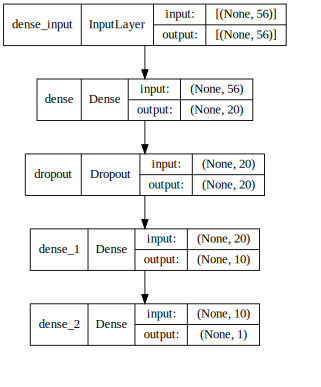

In [42]:
# Visualize network architecture
SVG(model_to_dot(model, show_shapes=True,show_layer_names=True, dpi=65).create(prog="dot", format="svg"))